# Make naive predictions for each variable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('./italy_values_dataset.xlsx')

In [3]:
UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

In [4]:
def prepare_wide_dataset(df):
    if 'Indicator Name' not in df.columns:
        raise ValueError("Il DataFrame deve contenere una colonna 'Indicator Name'")

    original_indicator_order = df['Indicator Name'].unique()
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df_long = df.melt(id_vars='Indicator Name', value_vars=year_cols,
                    var_name='Year', value_name='Value')

    df_wide = df_long.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()
    
    df_wide['Year'] = df_wide['Year'].astype(int)
    df_wide = df_wide.sort_values('Year').reset_index(drop=True)
    df_wide.columns.name = None
    
    # rimuovo variabili inutilizzabili
    unusable_cols = [col for col in df_wide.columns if col in UNUSABLE]
    if unusable_cols:
        df_wide = df_wide.drop(columns=unusable_cols)

    final_column_order = ['Year']
    for indicator in original_indicator_order:
        if indicator in df_wide.columns:
            final_column_order.append(indicator)
    df_wide = df_wide[final_column_order]
    return df_wide

In [ ]:
# # HISTORICAL MEAN BASELINE WITH MAPE EVALUATION
# def historical_mean(col, series):
#     split_idx = int(series.size*0.8)
#     train = series[:split_idx]
#     test = series[split_idx:]

#     historical_mean = np.mean(train['Value'])    
#     print(f"historical mean (train {train.length} values): {historical_mean}")
#     test.loc[:, 'pred_mean'] = historical_mean # aggiunge colonna pred_mean con il valore della media storica

#     # definisco funzione MAPE che calcola l'errore percentuale assoluto medio
#     def mape(y_true, y_pred):
#         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#     mape__hist_mean = mape(test['Value'], test['pred_mean'])
#     print("MAPE (test 3 values):", mape__hist_mean)

#     # plot
#     fig, ax = plt.subplots()
#     ax.plot(train['Year'], train['Value'], 'g-', label='Train')
#     ax.plot(test['Year'], test['Value'], 'b-', label='Test')
#     ax.plot(test['Year'], test['pred_mean'], 'r--', label='Predicted')
#     ax.set_title(f'{col} - Historical Mean (MAPE: {mape__hist_mean:.2f}%)')
#     ax.set_xlabel('Year')
#     ax.set_ylabel(f'{col}')
#     ax.axvspan(2020, 2022, color='#808080', alpha=0.2)
#     ax.legend(loc=2)
#     plt.xticks(np.arange(1960, 2022, 5), [str(year) for year in np.arange(1960, 2022, 5)])
#     plt.tight_layout()

In [38]:
# ridefinisco la funzione in modo corretto e robusto
def historical_mean(col, df_wide):
    # preparo la serie con colonne Year e Value
    series = df_wide[['Year', col]].rename(columns={col: 'Value'}).dropna(subset=['Value']).reset_index(drop=True)
    if series.empty:
        print(f"Skipping {col}: no data")
        return

    n = len(series)
    split_idx = int(n * 0.8)
    if split_idx == 0 or split_idx >= n:
        print(f"Skipping {col}: not enough data for train/test split (n={n})")
        return

    train = series.iloc[:split_idx].copy()
    test = series.iloc[split_idx:].copy()

    hist_mean = train['Value'].mean()
    print(f"{col} - historical mean (train {len(train)} values): {hist_mean}")

    test['pred_mean'] = hist_mean

    # funzione MAPE robusta (evita divisione per zero)
    def mape(y_true, y_pred):
        mask = y_true != 0
        if not mask.any():
            return np.nan
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    mape_hist = mape(test['Value'].values, test['pred_mean'].values)
    print(f"MAPE (test {len(test)} values): {mape_hist:.2f}%")

    # plot
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.plot(train['Year'], train['Value'], 'g-', label='Train')
    ax.plot(test['Year'], test['Value'], 'b-', label='Test')
    ax.plot(test['Year'], test['pred_mean'], 'r--', label='Predicted (historical mean)')
    ax.set_title(f'{col} - Historical Mean (MAPE: {mape_hist:.2f}%)')
    ax.set_xlabel('Year')
    ax.set_ylabel(col)
    # evidenzio con fascia grigia gli anni del test set (robusto anche per singolo anno)
    test_start = int(test['Year'].min())
    test_end = int(test['Year'].max())
    ax.axvspan(test_start, test_end, color='#808080', alpha=0.2)
    ax.legend(loc='best')

    min_year = int(df_wide['Year'].min())
    max_year = int(df_wide['Year'].max())
    xticks = np.arange(min_year, max_year + 1, 5)
    plt.xticks(xticks, [str(y) for y in xticks], rotation=45)
    plt.tight_layout()
    plt.show()


Rural population (% of total population) - historical mean (train 52 values): 34.20125
MAPE (test 13 values): 15.95%


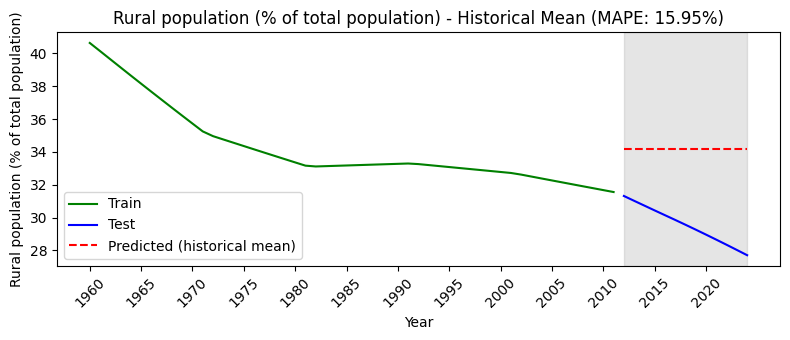

Rural population growth (annual %) - historical mean (train 51 values): -0.14545428021041765
MAPE (test 13 values): 85.67%


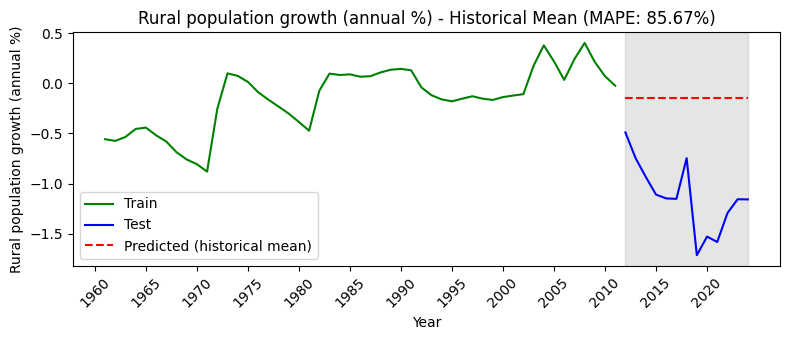

Rural population - historical mean (train 52 values): 19052926.634615384
MAPE (test 13 values): 8.17%


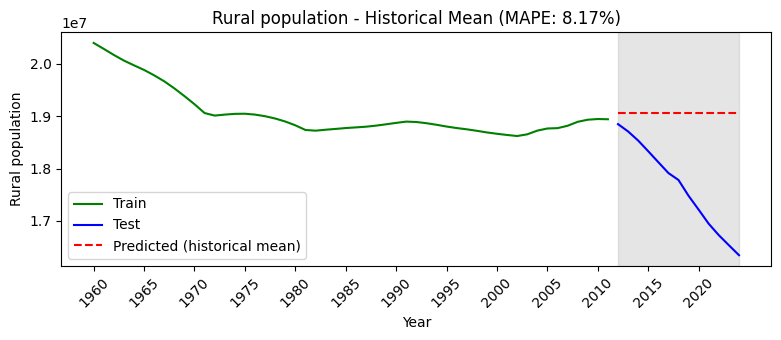

Employment in agriculture (% of total employment) - historical mean (train 26 values): 5.010655435052986
MAPE (test 7 values): 30.84%


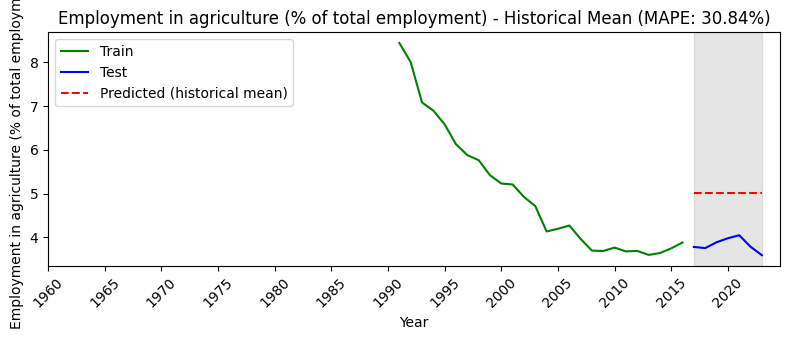

Employment in agriculture, male (% of male employment) - historical mean (train 26 values): 5.5105655087467325
MAPE (test 7 values): 12.61%


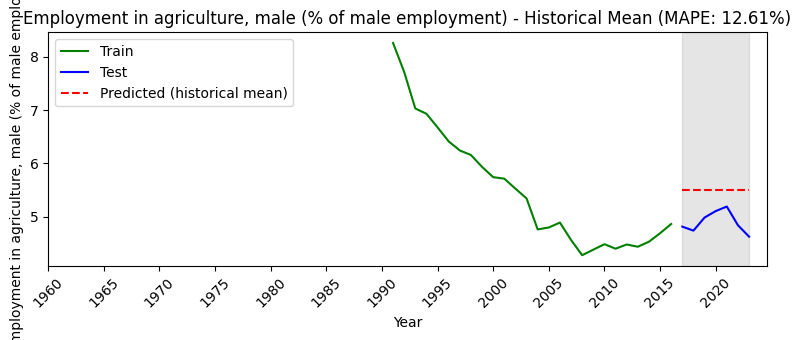

Employment in agriculture, female (% of female employment) - historical mean (train 26 values): 4.251096338286056
MAPE (test 7 values): 80.35%


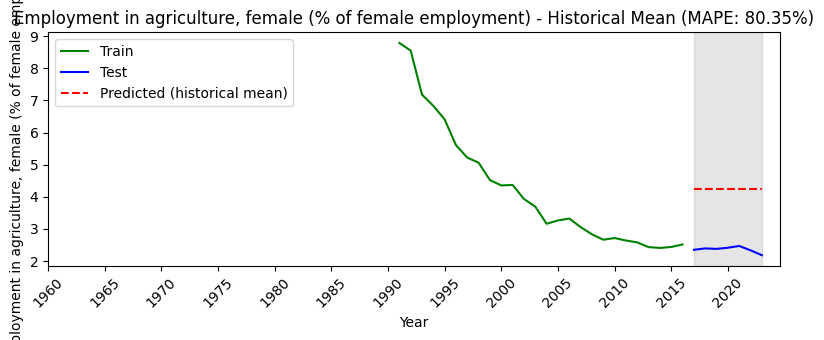

Forest area (% of land area) - historical mean (train 26 values): 28.804963443645565
MAPE (test 7 values): 10.44%


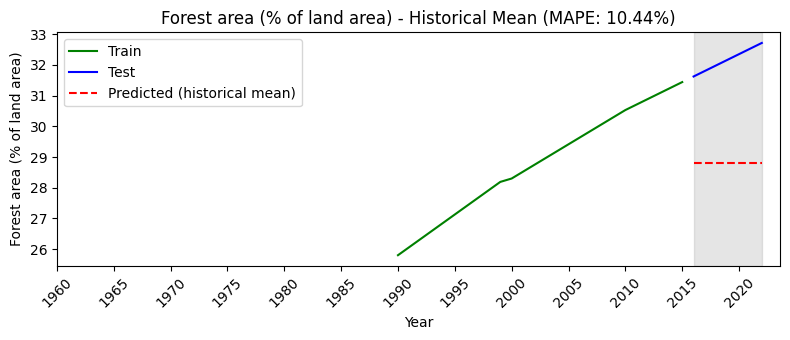

Forest area (sq. km) - historical mean (train 26 values): 85014.48653846154
MAPE (test 7 values): 10.62%


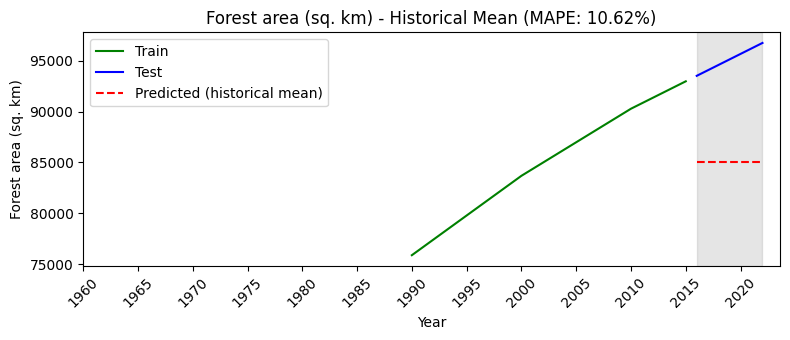

Agricultural land (% of land area) - historical mean (train 49 values): 58.211056181127354
MAPE (test 13 values): 31.31%


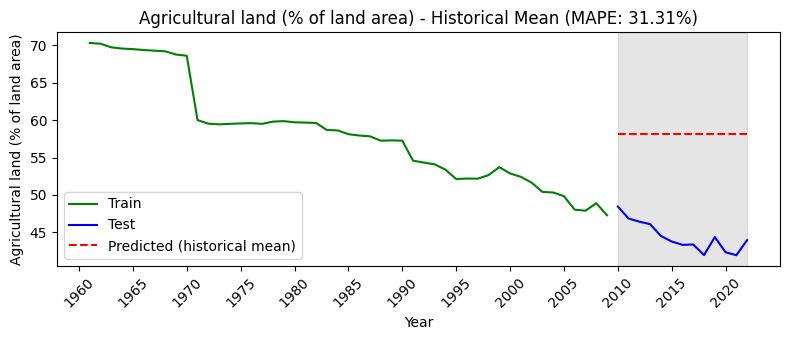

Agricultural land (sq. km) - historical mean (train 48 values): 172025.66666666666
MAPE (test 13 values): 30.51%


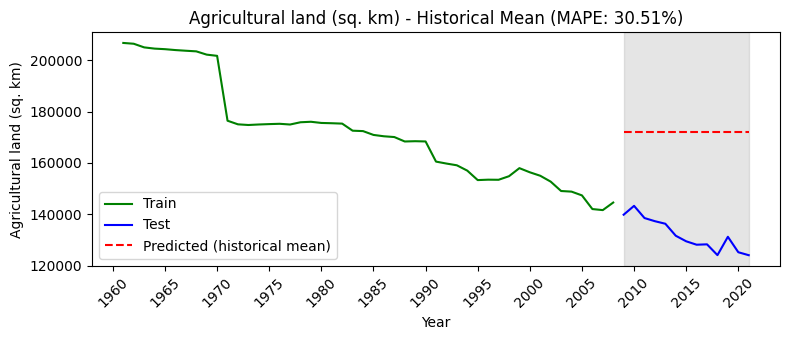

Arable land (% of land area) - historical mean (train 49 values): 32.18431305213388
MAPE (test 13 values): 38.23%


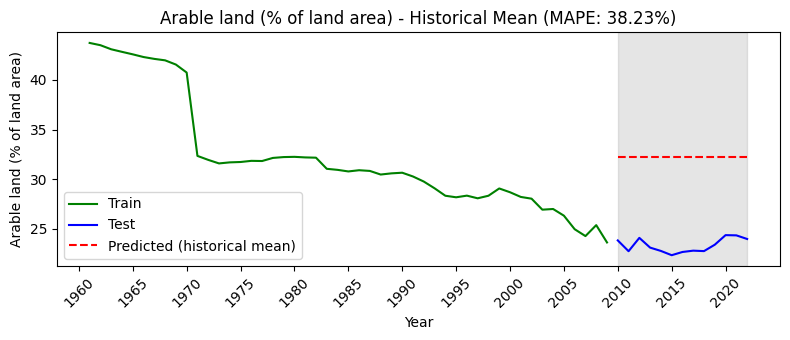

Arable land (hectares per person) - historical mean (train 48 values): 0.1722436642055956
MAPE (test 13 values): 50.10%


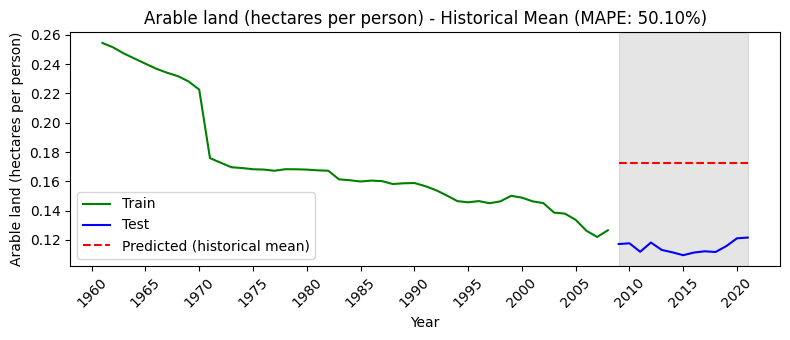

Arable land (hectares) - historical mean (train 48 values): 9526312.5
MAPE (test 13 values): 38.51%


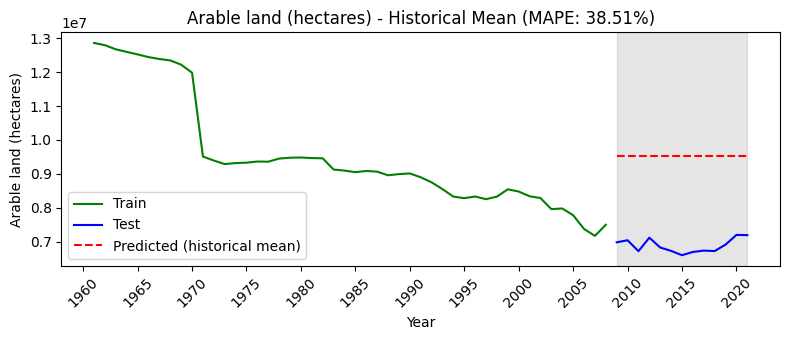

Land under cereal production (hectares) - historical mean (train 49 values): 4872527.8367346935
MAPE (test 13 values): 50.99%


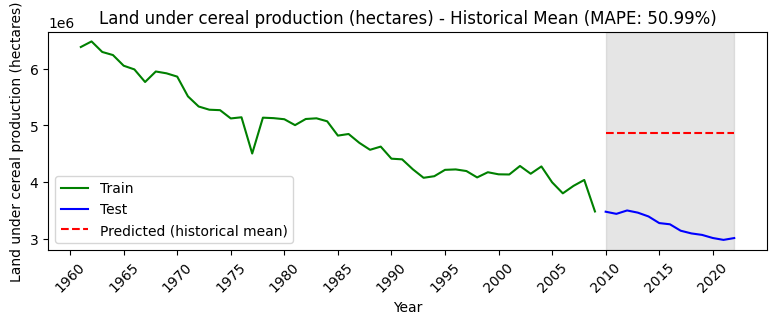

Permanent cropland (% of land area) - historical mean (train 49 values): 9.643117282946234
MAPE (test 13 values): 19.21%


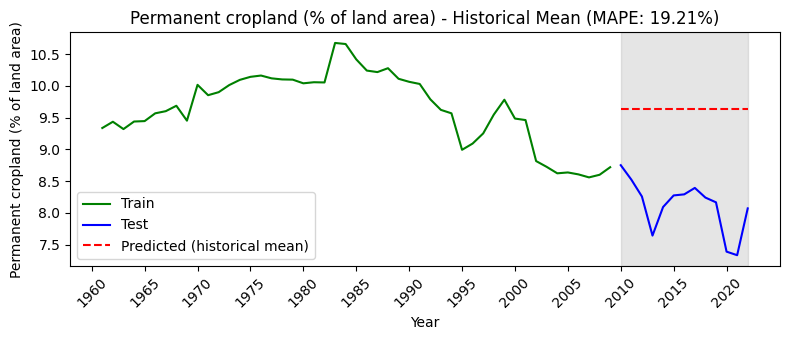

Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal) - historical mean (train 41 values): 49.39477804471707
MAPE (test 11 values): 1.89%


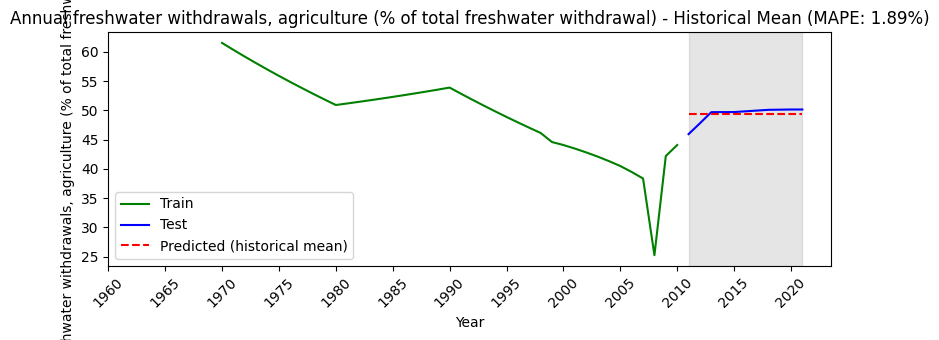

Fertilizer consumption (kilograms per hectare of arable land) - historical mean (train 49 values): 175.62522529664352
MAPE (test 13 values): 39.16%


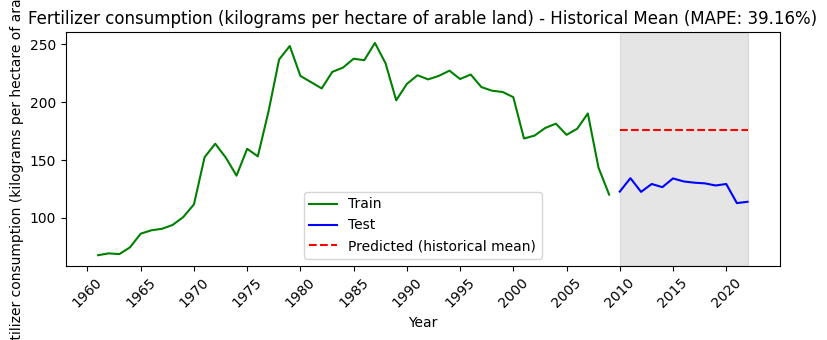

Fertilizer consumption (% of fertilizer production) - historical mean (train 49 values): 171.63685046272573
MAPE (test 13 values): 38.99%


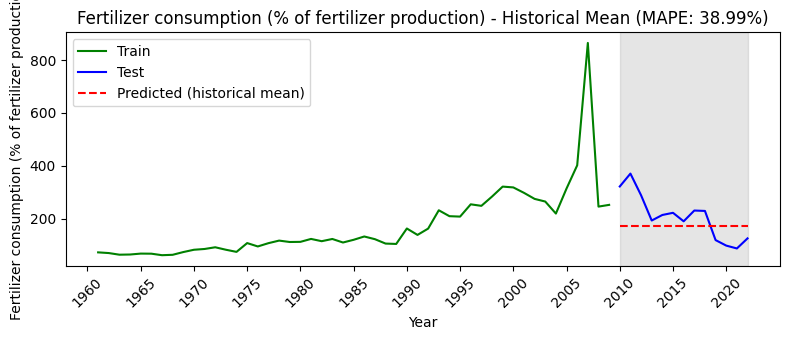

Livestock production index (2014-2016 = 100) - historical mean (train 49 values): 97.32183673469389
MAPE (test 13 values): 6.83%


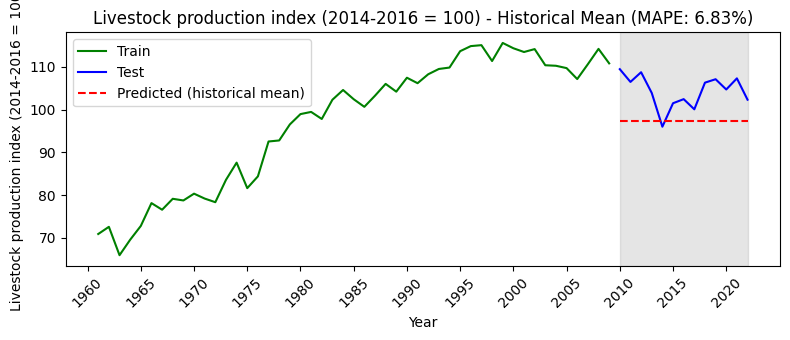

Food production index (2014-2016 = 100) - historical mean (train 49 values): 106.05693877551022
MAPE (test 13 values): 5.71%


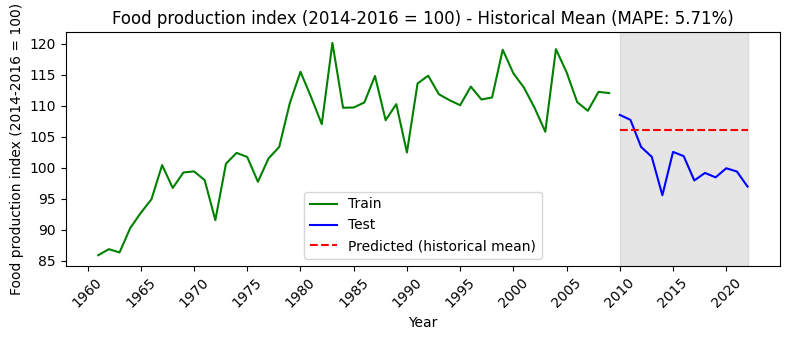

Crop production index (2014-2016 = 100) - historical mean (train 49 values): 111.12938775510206
MAPE (test 13 values): 12.20%


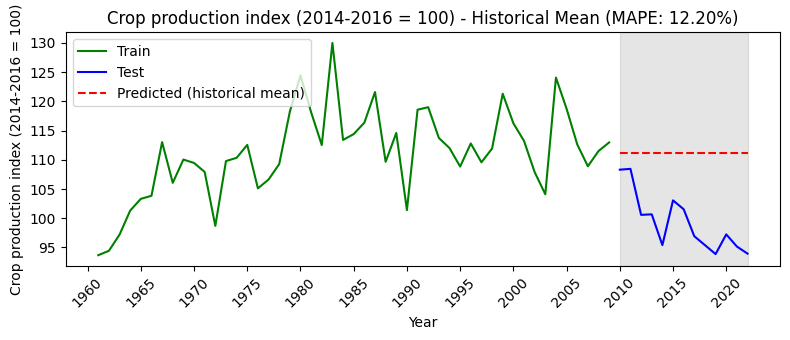

Cereal production (metric tons) - historical mean (train 49 values): 17934649.18367347
MAPE (test 13 values): 7.27%


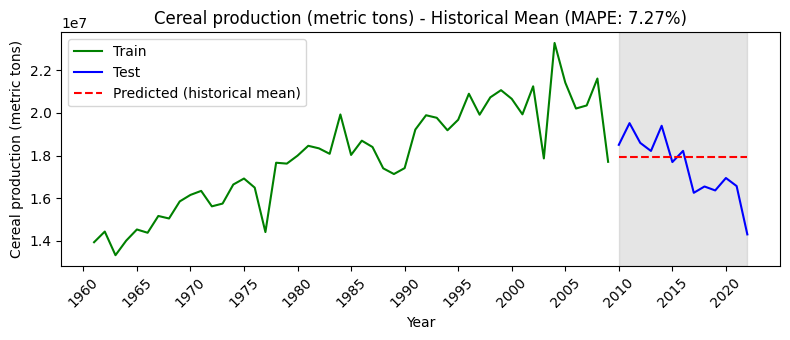

Cereal yield (kg per hectare) - historical mean (train 49 values): 3834.3306122448976
MAPE (test 13 values): 28.73%


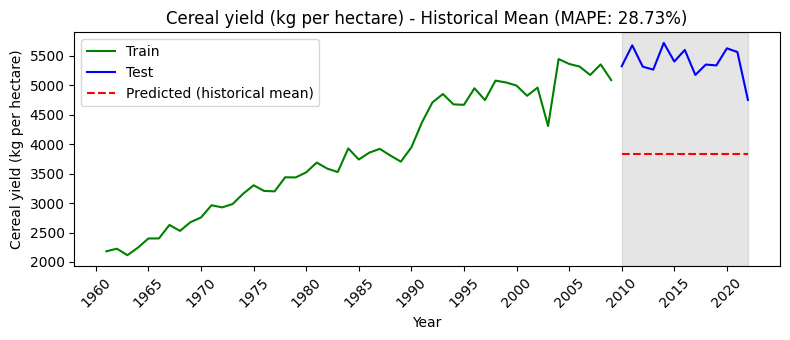

Agriculture, forestry, and fishing, value added (% of GDP) - historical mean (train 28 values): 2.3810096927937603
MAPE (test 7 values): 26.19%


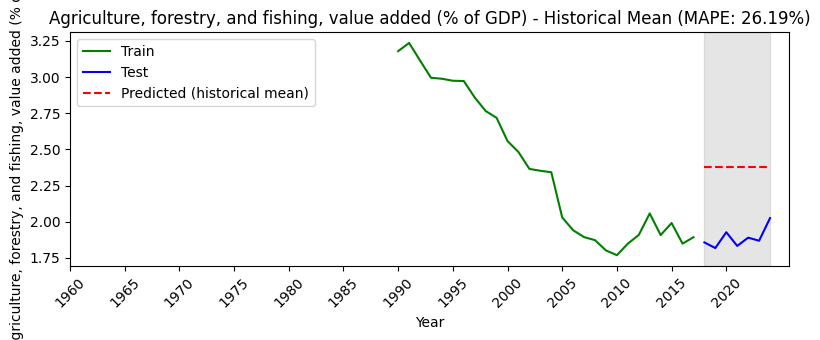

Agriculture, forestry, and fishing, value added (current US$) - historical mean (train 28 values): 37504794788.15178
MAPE (test 7 values): 7.81%


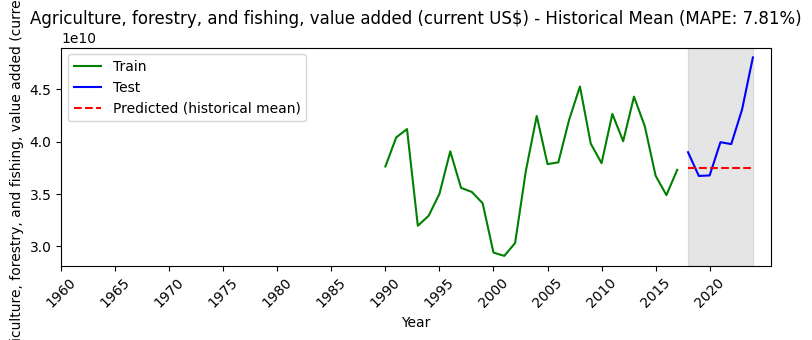

Agricultural raw materials exports (% of merchandise exports) - historical mean (train 50 values): 1.1585668260028044
MAPE (test 13 values): 64.77%


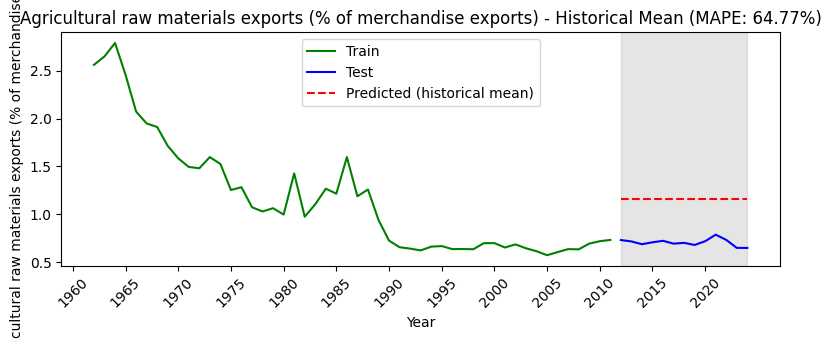

Agricultural raw materials imports (% of merchandise imports) - historical mean (train 50 values): 6.886714012369014
MAPE (test 13 values): 253.30%


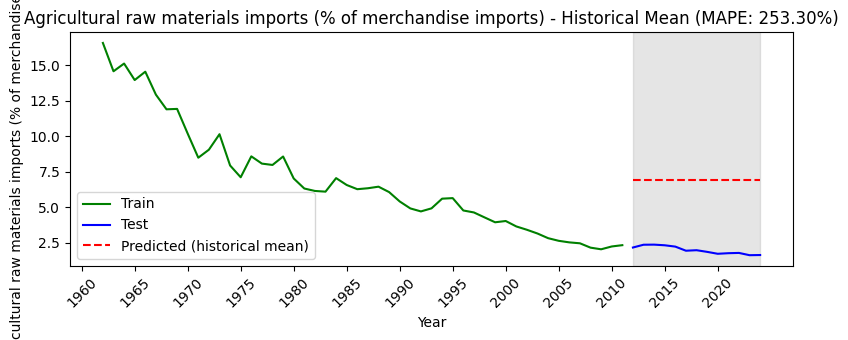

In [39]:
wide_df = prepare_wide_dataset(df)

for col in wide_df.columns:
    if col == 'Year':
        continue
    if not np.issubdtype(wide_df[col].dtype, np.number):
        print(f"Skipping {col}: non-numeric dtype")
        continue
    if wide_df[col].dropna().empty:
        print(f"Skipping {col}: all NaN")
        continue
    historical_mean(col, wide_df)